# Skills-ML Tour

Skills-ML is an open source software library for applying NLP and ML to labor market data. It allows the user to perform tasks like skill extraction and occupation classification to collections of documents such as job postings, profiles, and course descriptions.

## Competency

A competency is any expertise or talent that is useful for a job. Developed capacities (e.g. active listening), proficiency with tools or technology (e.g. lancets, Microsoft Word), innate abilities (e.g. originality), and academic knowledge (e.g. medicine) are all considered competencies.

In [1]:
from skills_ml.ontologies import Competency

dinosaur_riding = Competency(
    identifier='dino_riding',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

### Competency Relationships

Competencies are often related to each other. Defining parent-child relationships is a standard building block of existing competency frameworks like ONET and ESCO. A parent-child relationship generally implies that the child is a "type of" the parent.

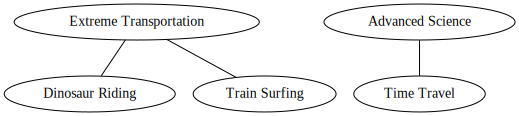

In [2]:
from skills_ml.ontologies import Competency
from skills_ml.ontologies.viz import display_nodes

dinosaur_riding = Competency(
    identifier='12345',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

train_surfing = Competency(
    identifier='12346',
    name='Train Surfing',
    description='Standing on the train while it goes'
)

time_travel = Competency(
    identifier='23456',
    name='Time Travel',
    description='Traveling Through Time'
)

advanced_science = Competency(
    identifier='2345',
    name='Advanced Science',
)

extreme_transportation = Competency(
    identifier='123',
    name='Extreme Transportation',
    description='Comically dangerous forms of transportation'
)
time_travel.add_parent(advanced_science)
dinosaur_riding.add_parent(extreme_transportation)
train_surfing.add_parent(extreme_transportation)
display_nodes([dinosaur_riding, train_surfing, extreme_transportation, time_travel, advanced_science])

## Occupation

An occupation is a job or profession that a person can hold. Similar to competencies, these are also often defined hierarchically.


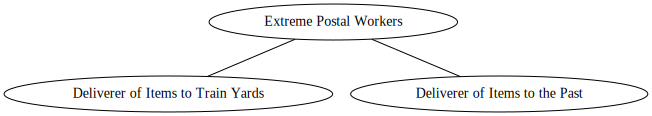

In [3]:
from skills_ml.ontologies import Occupation

extreme_postal_workers = Occupation(identifier='999', name='Extreme Postal Workers')
dino_postal_worker = Occupation(identifier='9998', name='Deliverer of Items to the Past')
train_yard_postal_worker = Occupation(identifier='9999', name='Deliverer of Items to Train Yards')
dino_postal_worker.add_parent(extreme_postal_workers)
train_yard_postal_worker.add_parent(extreme_postal_workers)

display_nodes([extreme_postal_workers, dino_postal_worker, train_yard_postal_worker])

# CompetencyOntology

A CompetencyOntology is a model of the labor market, or some subset thereof, consisting of a collection of competencies, a collection of occupations, and all of the relationships between them.

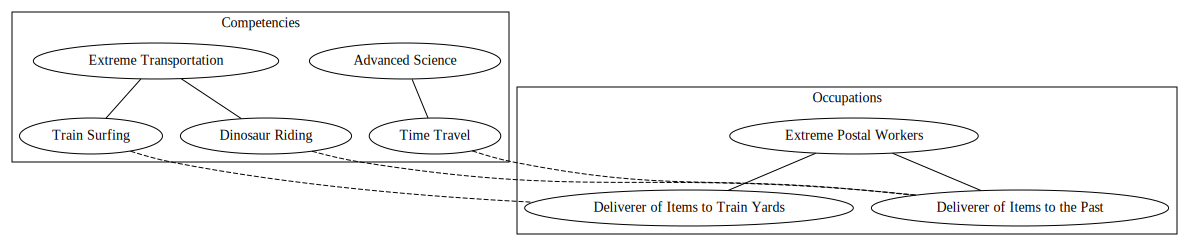

In [4]:
from skills_ml.ontologies import CompetencyOntology
from skills_ml.ontologies.viz import display_ontology

ontology = CompetencyOntology()
ontology.add_competency(dinosaur_riding)
ontology.add_competency(train_surfing)
ontology.add_competency(extreme_transportation)
ontology.add_competency(time_travel)
ontology.add_competency(advanced_science)

ontology.add_occupation(dino_postal_worker)
ontology.add_occupation(train_yard_postal_worker)
ontology.add_occupation(extreme_postal_workers)

ontology.add_edge(occupation=dino_postal_worker, competency=dinosaur_riding)
ontology.add_edge(occupation=dino_postal_worker, competency=time_travel)
ontology.add_edge(occupation=train_yard_postal_worker, competency=train_surfing)

display_ontology(ontology)

## Prebuilt Ontologies

To move on we'll want to level up to a full ontology. The example we'll use is O\*NET, built from survey data and maintained by the US Department of Labor. A CompetencyOntology subclass that downloads the source files from the O\*NET web site is included in Skills-ML.

In [5]:
from skills_ml.ontologies.onet import Onet
onet = Onet()
onet.print_summary_stats()

Ontology summary statistics for onet
Num competencies: 34100
Num occupations: 1133
Num competency-occupation edges: 124584
Median occupations per competency: 1
Median competencies per occupation: 107


In [7]:
list(onet.competencies)[0:5]

[Competency(identifier=43233506-Ben Meadows Yeoman Expedition, name=Ben Meadows Yeoman Expedition, categories=['Technology', 'O*NET T2'], {}),
 Competency(identifier=41113106, name=Infra red or ultra violet absorption analyzers, categories=['Tools', 'UNSPSC Commodity'], {}),
 Competency(identifier=27111503, name=Utility knives, categories=['Tools', 'UNSPSC Commodity'], {}),
 Competency(identifier=41113644-Circuit tracers, name=Circuit tracers, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=52161518-Real-time kinematics RTK global positioning systems GPS, name=Real-time kinematics RTK global positioning systems GPS, categories=['Tools', 'O*NET T2'], {})]

### Filtering

~34000 competencies and ~1100 occupations is a lot. Let's explore the filtering functionality of the CompetencyOntology to zoom in on a more specific slice.

`filter_by` filters using edges: the filtering function it expects takes in an edge (between a Competency and Occupation) and returns whether or not it should be in the result. The result takes the form of a new CompetencyOntology, so you can interact with it in the same way as you would the source ontology. 

In [24]:
nurse_practitioners = onet.filter_by(lambda edge: 'Nurse Practitioners' in edge.occupation.name)
nurse_practitioners.competencies

{Competency(identifier=1.A.1.a.1, name=Oral Comprehension, categories=['Abilities'], {'competencyText': 'The ability to listen to and understand information and ideas presented through spoken words and sentences.'}),
 Competency(identifier=1.A.1.a.2, name=Written Comprehension, categories=['Abilities'], {'competencyText': 'The ability to read and understand information and ideas presented in writing.'}),
 Competency(identifier=1.A.1.a.3, name=Oral Expression, categories=['Abilities'], {'competencyText': 'The ability to communicate information and ideas in speaking so others will understand.'}),
 Competency(identifier=1.A.1.a.4, name=Written Expression, categories=['Abilities'], {'competencyText': 'The ability to communicate information and ideas in writing so others will understand.'}),
 Competency(identifier=1.A.1.b.1, name=Fluency of Ideas, categories=['Abilities'], {'competencyText': 'The ability to come up with a number of ideas about a topic (the number of ideas is important, not 

That's a big list of competencies. Each competency has a list of categories, so let's get all of the different possible categories

In [12]:
set(cat for competency in nurse_practitioners.competencies for cat in competency.categories)

{'Abilities', 'DWA', 'Knowledge', 'O*NET T2', 'Skills', 'Technology', 'Tools'}

So we can ask questions like: what type of Knowledge do nurse practitioners need?

In [25]:
[competency for competency in nurse_practitioners.competencies if 'Knowledge' in competency.categories]

[Competency(identifier=2.C.4.e, name=Psychology, categories=['Knowledge'], {'competencyText': 'Knowledge of human behavior and performance; individual differences in ability, personality, and interests; learning and motivation; psychological research methods; and the assessment and treatment of behavioral and affective disorders.'}),
 Competency(identifier=2.C.4.a, name=Mathematics, categories=['Knowledge'], {'competencyText': 'Knowledge of arithmetic, algebra, geometry, calculus, statistics, and their applications.'}),
 Competency(identifier=2.C.4.f, name=Sociology and Anthropology, categories=['Knowledge'], {'competencyText': 'Knowledge of group behavior and dynamics, societal trends and influences, human migrations, ethnicity, cultures and their history and origins.'}),
 Competency(identifier=2.C.7.a, name=English Language, categories=['Knowledge'], {'competencyText': 'Knowledge of the structure and content of the English language including the meaning and spelling of words, rules o

# Input Datasets Placeholder

In [26]:
from skills_ml.job_postings.common_schema import JobPostingCollectionSample
job_posting_generator = JobPostingCollectionSample()

# Skill Extraction

A common task is extracting competencies from unstructured text. Sometimes this is ontology-based (finding concepts from a known ontology in text), but this is not necessarily true. Skills-ML unites these with a common interface in the SkillExtractor class. The common interface is that every SkillExtractor needs to be able to take in a collection of documents, and yield what we call `CandidateSkill` objects.

## What Is a CandidateSkill?

A CandidateSkill is a possible occurrence of a skill/competency in context in some document. It consists of the following fields:

`skill_name` - The text version of the skill as it appears in the document

`matched_skill_identifier` - A reference to the skill in some ontology. This may be empty, if no ontology was used to search for skills.

`context` - The text surrounding the skill in the document. The goal is for a human labeler to be able to use this to determine whether or not the occurrence represents a true skill. How much context is included is up to the algorithm.

`start_index` - The start index of the skill occurrence within the document string.

`confidence` - The confidence level the algorithm has in this candidate skill being a true occurrence of a skill. This may be empty, if the algorithm has now way of producing a confidence value.

`document_id` - A unique identifier for the source document.

`document_type` - The type of document (examples: Job Posting, Profile, Course Description)

`source_object` - The entire source document.

`skill_extractor_name` - The name of the skill extractor algorithm. Every SkillExtractor subclass defines a name property that is used to give processes downstream context about how their output data was produced.

The idea behind the CandidateSkill object is to serve as a common interface between SkillExtractor objects, automatic evaluation methods, and manual evaluation methods.

- A labeling interface might intake CandidateSkill objects for humans to say yes/no to.
- Another type of labeling interface might involve the export of CandidateSkill objects based on what a human highlighted in the interface when shown the entire document
- Unsupervised evaluation metrics may take in one set of CandidateSkills to produce simple descriptive metrics
- Supervised evaluation metrics may take in one set of CandidateSkills from a SkillExtractor and another set of CandidateSkills from a human labeling interface and use the latter to evaluate the former

We'll talk about some of these use cases in more detail later. But for now, let's start with a simple example that uses NLP rules and isn't tied to an ontology. Let's define a method for extracting skills as 'all noun phrases that end in the word skill or skills'. This is a simple method that realistically won't cover all possible occurrences of skills, but this is a start.

In [35]:
from skills_ml.algorithms.skill_extractors import SkillEndingPatternExtractor

# instantiate the skill extractor. This class defaults to only considering lines that
# start with a bullet, which doesn't work for this dataset. So we set this flag to False.
skill_extractor = SkillEndingPatternExtractor(only_bulleted_lines=False)
job_posting = next(iter(job_posting_generator))
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

skill name: communication skills
context: Excellent client presentation and communication skills as well as strong customer service and organizational skills.

skill name: organizational skills
context: Excellent client presentation and communication skills as well as strong customer service and organizational skills.

skill name: communication skills
context: We are proud to be an equal opportunity employer College degree preferred, 2 - 5 years experience in print and / or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self - motivated, team - oriented, and customer - ce

The results for one job posting are modest. Two distinct skill names, each occurring two different times in the document.  This is a start.

Now let's try another skill extractor: matching with ONET data.

In [36]:
from skills_ml.algorithms.skill_extractors import ExactMatchSkillExtractor
skill_extractor = ExactMatchSkillExtractor(onet.competency_framework)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

skill name: self
context: The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.

skill name: self
context: We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential customers and use online analytics from a sales perspective, Weekly local travel to meet with clients/prospects is required, Minimal non local travel a few times a year is required



Yikes. What is this? As it turns out, ['Self' is a real programming language](https://en.wikipedia.org/wiki/Self_(programming_language)). But it's not applicable here. Simply searching for skill names has its limitations.

To help with this, there is also the SocScopedExactMatchSkillExtractor. This does exact matching, but only for the occupation that the document is tagged with. This, of course, is only applicable if the document has one. And it needs a full CompetencyOntology to work.

In [37]:
from skills_ml.algorithms.skill_extractors import SocScopedExactMatchSkillExtractor
skill_extractor = SocScopedExactMatchSkillExtractor(onet)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

No results. This is expected: For an occupation that is not related to computer programming, the language 'Self' is likely irrelevant.

Here's a list of all the other skill extractors available.

`FuzzyMatchSkillExtractor` - Similar to the ExactMatchSkillExtractor, but using a configurable edit distance to find skill names that are very close to the targets.

`AbilityEndingPatternExtractor` - Similar to the SkillEndingPatternExtractor, but finding noun phrases that end in 'ability' or 'abilities'.

`SectionExtractSkillExtractor` - Attempts to divide the text into sections with headers, which is a common pattern found in job postings. Return each individual sentence found in sections with certain headers (Skills, Competencies, Qualifications).